In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import Dataset

from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from transformers.utils import is_torch_bf16_gpu_available
from transformers import AutoModelForCausalLM

from jigsaw.settings import DATA_DIR, MODEL_DIR


train_path = DATA_DIR / "ds_no_examples_train.ds"
eval_path = DATA_DIR / "ds_no_examples_eval.ds"

train_dataset = Dataset.load_from_disk(str(train_path))
eval_dataset = Dataset.load_from_disk(str(eval_path))

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    task_type="CAUSAL_LM",
)

training_args = SFTConfig(
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    optim="paged_adamw_8bit",
    learning_rate=1e-4,  # keep high, lora usually likes high.
    weight_decay=0.01,
    max_grad_norm=1.0,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    bf16=is_torch_bf16_gpu_available(),
    fp16=not is_torch_bf16_gpu_available(),
    dataloader_pin_memory=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    save_strategy="no",
    report_to="none",
    packing=False,
    remove_unused_columns=False,
    completion_only_loss=True,
)

In [3]:
train_dataset[0]

{'prompt': [{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/photoshopbattles </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>FindSexToday . com - free girls for sex worldwide 40hygzJvUtS14!</comment>",
   'role': 'user'}],
 'completion': [{'content': 'yes', 'role': 'assistant'}]}

In [4]:
BASE_MODEL_PATH = "Qwen/Qwen3-0.6B"  # Model to fine-tune
LORA_PATH = MODEL_DIR / "lora_checkpoint.pt"  # Where to save LoRA weights

In [5]:
# model = AutoModelForCausalLM.from_pretrained(
#     BASE_MODEL_PATH, dtype="auto", device_map="auto"
# )


In [6]:
# trainer = SFTTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     peft_config=lora_config,
# )

# trainer.train()
# trainer.save_model(LORA_PATH)

In [7]:
import vllm
from vllm.lora.request import LoRARequest

llm = vllm.LLM(
    BASE_MODEL_PATH,
    quantization=None,  # "gptq",
    tensor_parallel_size=1,
    gpu_memory_utilization=0.7,
    trust_remote_code=True,
    dtype="half",
    enforce_eager=True,
    max_model_len=2836,
    disable_log_stats=True,
    enable_prefix_caching=True,
    enable_lora=True,
    max_lora_rank=64,
)

tokenizer = llm.get_tokenizer()
# mclp = MultipleChoiceLogitsProcessor(tokenizer, choices=["yes", "no"])

texts = eval_dataset["prompt"]

INFO 10-17 18:37:28 [__init__.py:235] Automatically detected platform cuda.


`torch_dtype` is deprecated! Use `dtype` instead!


WARNING 10-17 18:37:34 [config.py:3443] Casting torch.bfloat16 to torch.float16.
INFO 10-17 18:37:34 [config.py:1604] Using max model len 2836
INFO 10-17 18:37:35 [config.py:2434] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 10-17 18:37:36 [__init__.py:2899] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reason: CUDA is initialized
INFO 10-17 18:37:39 [__init__.py:235] Automatically detected platform cuda.
INFO 10-17 18:37:40 [core.py:572] Waiting for init message from front-end.
INFO 10-17 18:37:40 [core.py:71] Initializing a V1 LLM engine (v0.10.0) with config: model='Qwen/Qwen3-0.6B', speculative_config=None, tokenizer='Qwen/Qwen3-0.6B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, m

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  4.00it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  4.00it/s]



INFO 10-17 18:37:43 [default_loader.py:262] Loading weights took 0.27 seconds
INFO 10-17 18:37:43 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 10-17 18:37:43 [gpu_model_runner.py:1892] Model loading took 1.1957 GiB and 1.186418 seconds
INFO 10-17 18:37:45 [gpu_worker.py:255] Available KV cache memory: 2.73 GiB
INFO 10-17 18:37:45 [kv_cache_utils.py:833] GPU KV cache size: 25,568 tokens
INFO 10-17 18:37:45 [kv_cache_utils.py:837] Maximum concurrency for 2,836 tokens per request: 8.98x
INFO 10-17 18:37:45 [core.py:193] init engine (profile, create kv cache, warmup model) took 2.12 seconds


In [ ]:
tokenizer = llm.get_tokenizer()

outputs = llm.generate(
    [tokenizer.apply_chat_template(text, tokenize=False) for text in texts],
    vllm.SamplingParams(
        skip_special_tokens=True,
        max_tokens=10,
        logprobs=2,
    ),
    use_tqdm=True,
    lora_request=LoRARequest("default", 1, str(LORA_PATH))
)

log_probs = [
    {lp.decoded_token: lp.logprob for lp in out.outputs[0].logprobs[0].values()}
    for out in outputs
]

Adding requests:   0%|          | 0/1580 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1580 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

In [32]:
for sample, out in zip(eval_dataset, outputs[:10]):
    print(sample["prompt"])
    print(sample["completion"][0]["content"])
    print(out.outputs[0].text)
    print()


[{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/legaladvice </subreddit>. The rule is <rule> No legal advice: Do not offer or request legal advice. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>But the money changes hands. If the living person had just given all of that money to his siblings or children, it would have been taxed as a gift/income. How is this different? Money is taxed when it changes hands.</comment>", 'role': 'user'}]
no

</think>

no

[{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/aww </subreddit>. The rule is <rule> No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>Infographi

In [42]:
answers = []
for out in outputs:
    sample_lp = {}
    for lp in out.outputs[0].logprobs:
        if 2152 in lp:
            sample_lp['no'] = lp[2152].logprob
        if 9693 in lp:
            sample_lp['yes'] = lp[9693].logprob
    answers.append(sample_lp)


In [23]:
# Check eval_dataset structure
print(f"Eval dataset columns: {eval_dataset.column_names}")
print(f"\nFirst eval example:")
print(eval_dataset[0])


Eval dataset columns: ['prompt', 'completion']

First eval example:
{'prompt': [{'content': "You are an unbiased moderator that classifies comments as violating a rule or not. You are moderating for the subreddit <subreddit> r/legaladvice </subreddit>. The rule is <rule> No legal advice: Do not offer or request legal advice. </rule>. Does the given comment violate the rule? Respond with 'yes' or 'no'.Comment: <comment>But the money changes hands. If the living person had just given all of that money to his siblings or children, it would have been taxed as a gift/income. How is this different? Money is taxed when it changes hands.</comment>", 'role': 'user'}], 'completion': [{'content': 'no', 'role': 'assistant'}]}


In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# Extract true labels from eval_dataset
# Assuming completion contains the assistant's response which is "yes" or "no"
true_labels = []
for example in eval_dataset:
    # Get the assistant message from completion
    if isinstance(example['completion'], list):
        # If it's a list of messages, find the assistant message
        assistant_msg = [msg for msg in example['completion'] if msg.get('role') == 'assistant']
        if assistant_msg:
            answer = assistant_msg[0]['content'].strip().lower()
        else:
            answer = example['completion'][0].get('content', '').strip().lower()
    else:
        answer = str(example['completion']).strip().lower()
    
    # Convert to binary: 1 for "yes" (violation), 0 for "no" (no violation)
    true_labels.append(1 if answer == 'yes' else 0)

true_labels = np.array(true_labels)
print(f"Extracted {len(true_labels)} true labels")
print(f"Distribution: {np.sum(true_labels)} positives, {len(true_labels) - np.sum(true_labels)} negatives")


Extracted 1580 true labels
Distribution: 797 positives, 783 negatives


In [43]:
# Extract log probabilities for "yes" and "no"
yes_logprobs = []
no_logprobs = []

for lp_dict in answers:
    # Get log probabilities, default to very negative value if token not in top-k
    yes_lp = lp_dict.get('yes', lp_dict.get('Yes', -100.0))
    no_lp = lp_dict.get('no', lp_dict.get('No', -100.0))
    
    yes_logprobs.append(yes_lp)
    no_logprobs.append(no_lp)

yes_logprobs = np.array(yes_logprobs)
no_logprobs = np.array(no_logprobs)

print(f"Extracted log probabilities for {len(yes_logprobs)} examples")
print(f"Yes logprobs - min: {yes_logprobs.min():.4f}, max: {yes_logprobs.max():.4f}, mean: {yes_logprobs.mean():.4f}")
print(f"No logprobs - min: {no_logprobs.min():.4f}, max: {no_logprobs.max():.4f}, mean: {no_logprobs.mean():.4f}")


Extracted log probabilities for 1580 examples
Yes logprobs - min: -100.0000, max: -0.0024, mean: -2.5150
No logprobs - min: -6.0493, max: -0.0008, mean: -1.9818


In [44]:
# Calculate predictions based on which has higher log probability
# Predict "yes" (1) if yes_logprob > no_logprob, otherwise "no" (0)
predictions = (yes_logprobs > no_logprobs).astype(int)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Convert log probabilities to probabilities for AUC calculation
# Use softmax to get proper probabilities
yes_probs = np.exp(yes_logprobs)
no_probs = np.exp(no_logprobs)
total_probs = yes_probs + no_probs

# Probability of "yes" (positive class)
prob_yes = yes_probs / total_probs

# Calculate AUC
auc = roc_auc_score(true_labels, prob_yes)

print(f"\n{'='*50}")
print(f"VALIDATION METRICS")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"AUC Score: {auc:.4f}")
print(f"{'='*50}")



VALIDATION METRICS
Accuracy: 0.9500 (95.00%)
AUC Score: 0.9823


In [45]:
# Detailed breakdown
from sklearn.metrics import confusion_matrix, classification_report

print("\nConfusion Matrix:")
print("                 Predicted No  Predicted Yes")
cm = confusion_matrix(true_labels, predictions)
print(f"Actual No        {cm[0,0]:>12}  {cm[0,1]:>13}")
print(f"Actual Yes       {cm[1,0]:>12}  {cm[1,1]:>13}")

print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(
    true_labels, 
    predictions, 
    target_names=['No Violation', 'Violation'],
    digits=4
))

# Show some example predictions
print("\n" + "="*50)
print("Sample Predictions (first 10):")
print("="*50)
for i in range(min(10, len(true_labels))):
    true_label_str = "Yes" if true_labels[i] == 1 else "No"
    pred_label_str = "Yes" if predictions[i] == 1 else "No"
    match = "✓" if true_labels[i] == predictions[i] else "✗"
    print(f"{match} Example {i}: True={true_label_str}, Pred={pred_label_str}, "
          f"P(Yes)={prob_yes[i]:.4f}, LogP(Yes)={yes_logprobs[i]:.2f}, LogP(No)={no_logprobs[i]:.2f}")



Confusion Matrix:
                 Predicted No  Predicted Yes
Actual No                 743             40
Actual Yes                 39            758

Classification Report:
              precision    recall  f1-score   support

No Violation     0.9501    0.9489    0.9495       783
   Violation     0.9499    0.9511    0.9505       797

    accuracy                         0.9500      1580
   macro avg     0.9500    0.9500    0.9500      1580
weighted avg     0.9500    0.9500    0.9500      1580


Sample Predictions (first 10):
✓ Example 0: True=No, Pred=No, P(Yes)=0.3702, LogP(Yes)=-0.99, LogP(No)=-0.46
✓ Example 1: True=No, Pred=No, P(Yes)=0.2539, LogP(Yes)=-1.37, LogP(No)=-0.29
✓ Example 2: True=Yes, Pred=Yes, P(Yes)=0.9815, LogP(Yes)=-0.02, LogP(No)=-3.99
✓ Example 3: True=Yes, Pred=Yes, P(Yes)=0.9815, LogP(Yes)=-0.02, LogP(No)=-3.99
✓ Example 4: True=Yes, Pred=Yes, P(Yes)=0.9759, LogP(Yes)=-0.02, LogP(No)=-3.73
✓ Example 5: True=No, Pred=No, P(Yes)=0.0018, LogP(Yes)=-6.35, LogP

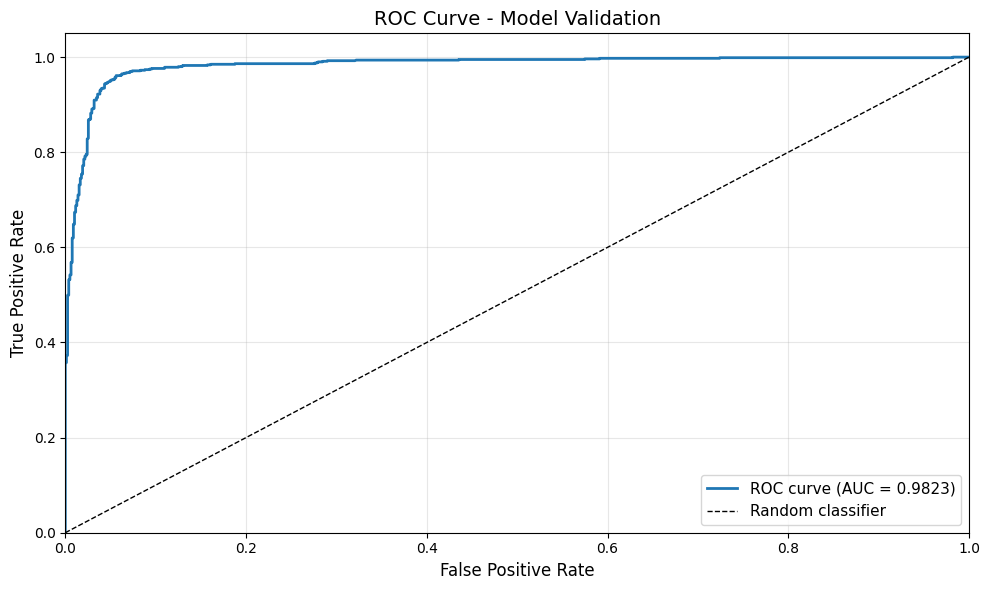

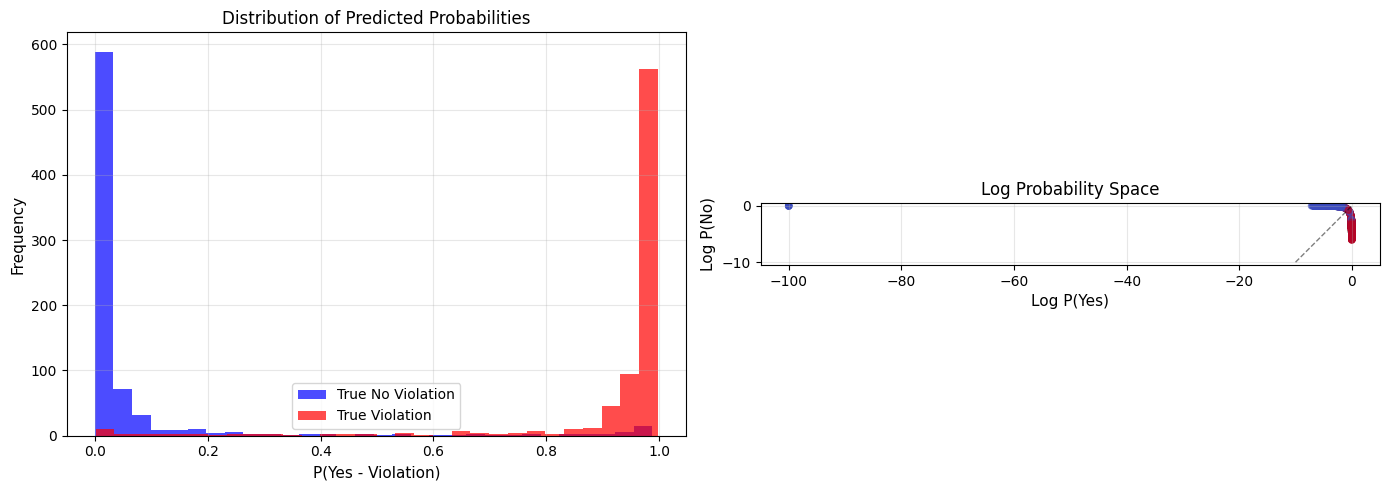

In [46]:
# Optional: Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(true_labels, prob_yes)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Model Validation', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot distribution of probabilities
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(prob_yes[true_labels == 0], bins=30, alpha=0.7, label='True No Violation', color='blue')
axes[0].hist(prob_yes[true_labels == 1], bins=30, alpha=0.7, label='True Violation', color='red')
axes[0].set_xlabel('P(Yes - Violation)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Predicted Probabilities', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(yes_logprobs, no_logprobs, c=true_labels, cmap='coolwarm', alpha=0.6, s=20)
axes[1].plot([-10, 0], [-10, 0], 'k--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Log P(Yes)', fontsize=11)
axes[1].set_ylabel('Log P(No)', fontsize=11)
axes[1].set_title('Log Probability Space', fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
